<a href="https://colab.research.google.com/github/heesukjang/W207_AppliedML_Fall2022/blob/main/Breast_Cancer_IDC_Prediction_Using_CNN_heesuk_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## FALL 2022<br>
W207 Applied Machine Learning<br>
Heesuk Jang
 

#Predicting IDC with Breast Histopathology Images using CNN



In [ ]:
import pandas as pd
import numpy as np
import os
import re
import random
import joblib
import glob

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib.patches as patches

from sklearn.utils import shuffle
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy import stats
from collections import Counter
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import *                            # confusion_matrix, log_loss, accuracy_score
from sklearn.model_selection import *                    # train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import preprocessing
from sklearn.preprocessing import *
# from sklearn.ensemble import *
from sklearn.svm import *
from sklearn.linear_model import *                       # LinearRegression
from sklearn.discriminant_analysis import *
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.plotting import plot_decision_regions

import tensorflow as tf
from keras import metrics
from tensorflow.keras import initializers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomZoom, RandomRotation, Conv2D, MaxPooling2D, AveragePooling2D, Input, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, SGD
tf.get_logger().setLevel('INFO')

import cv2 as cv
import skimage.io as io

import warnings
warnings.filterwarnings('ignore')

# Required to read the data from Kaggle
from google.colab import drive
# drive.mount('/content/gdrive')
# os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/MyDrive/Kaggle"

from google.colab import drive
drive.mount('/content/gdrive')

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

Mounted at /content/gdrive


In [ ]:
%pwd

'/content'

In [ ]:
# !unzip gdrive/MyDrive/Kaggle/CNN_IDC/Dataset.zip

#replace these paths with the paths of your 
val_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Validate'
train_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train'
test_image_directory = '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Test'
directory_path = '/content/gdrive/MyDrive/Kaggle/CNN_IDC'

In [ ]:
# directory_path

In [ ]:
def get_paths(directory):
  all_path = []
  idc_image_path = []
  idc_image_label = []

  for dir, subdir, files in os.walk(directory):
    path = dir + "/"
    all_path.append(path)

  for i in range(len(all_path)):
    for file in os.listdir(all_path[i]):
      test = file
      path = all_path[i] + test
      if path.lower().endswith('.png'):
        idc_image_path.append(path)

  for i in range(len(idc_image_path)):
    split_test = idc_image_path[i]
    split_path = split_test.split("/")
    directory_name = split_path[7]
    idc_image_label.append('class_' + split_path[8])
    # idc_image_label.append(str(split_path[8]))
  return idc_image_path, idc_image_label, directory_name

In [ ]:
train_paths, train_labels, train_dir = get_paths(train_image_directory)
val_paths, val_labels, val_dir = get_paths(val_image_directory)
test_paths, test_labels, test_dir = get_paths(test_image_directory)

In [ ]:
print(len(train_paths), len(train_labels))
print(len(test_paths), len(test_labels))
print(len(val_paths), len(val_labels))

800 800
200 200
200 200


In [ ]:
print(train_paths)
print(train_labels)
print(train_dir)

['/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12880_idx5_x451_y701_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9345_idx5_x2001_y2001_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12817_idx5_x2401_y201_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/10259_idx5_x2351_y251_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9322_idx5_x1301_y1451_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9322_idx5_x1951_y1301_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/14210_idx5_x1251_y1751_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/10278_idx5_x901_y1501_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/9261_idx5_x1151_y1051_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/12930_idx5_x1901_y1301_class0.png', '/content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset/Train/0/8867_idx5_x851_y1451_class0.png'

In [ ]:
def create_dataframes(idc_image_path, idc_image_label, directory_name):
  same_name = directory_name.lower() + '_'
  #creating the dataframes that we will be passing to our generators
  idc_data_cleaned = {'path': idc_image_path,
            'label': idc_image_label}
  idc_df = pd.DataFrame(idc_data_cleaned)
  df = idc_df.sample(frac = 1)
  print(df)
  csv_path = directory_path
  csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
  csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
  return csv_file_path

In [ ]:
# def create_dataframes(idc_image_path, idc_image_label, directory_name):
#   same_name = directory_name.lower() + '_'
#   #creating the dataframes that we will be passing to our generators
#   idc_data_cleaned = {'path': idc_image_path,
#             'label': idc_image_label}
#   idc_df = pd.DataFrame(idc_data_cleaned)
#   df = idc_df.sample(frac = 1)
#   print(df)
#   csv_path = directory_path
#   csv_file = df.to_csv(csv_path + '/' + same_name + 'idc_dataframe.csv')
#   # csv_file_path = csv_path + '/' + same_name + 'idc_dataframe.csv'
#   return csv_file

In [ ]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
print(type(train_dataframe))
train_dataframe

                                                  path    label
297  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
637  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
387  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
485  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
674  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
..                                                 ...      ...
740  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
122  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
119  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
516  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
777  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1

[800 rows x 2 columns]
<class 'str'>


'/content/gdrive/MyDrive/Kaggle/CNN_IDC/train_idc_dataframe.csv'

In [ ]:
train_dataframe = create_dataframes(train_paths, train_labels, train_dir)
train_generator = pd.read_csv(train_dataframe)

test_dataframe = create_dataframes(test_paths, test_labels, test_dir)
test_generator = pd.read_csv(test_dataframe)

val_dataframe = create_dataframes(val_paths, val_labels, val_dir)
val_generator = pd.read_csv(val_dataframe)

                                                  path    label
461  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
719  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
267  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
670  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
89   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
..                                                 ...      ...
407  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
65   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
530  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
422  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
365  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0

[800 rows x 2 columns]
                                                  path    label
149  /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_1
50   /content/gdrive/MyDrive/Kaggle/CNN_IDC/Dataset...  class_0
152  /content/gd

In [ ]:
data_generator = ImageDataGenerator()

train_data_generator = data_generator.flow_from_dataframe(
    train_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    featurewise_center = True,
    featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
    # seed=1234
    # validate_filenames=True
)

validation_data_generator = data_generator.flow_from_dataframe(
    val_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    featurewise_center = True,
    featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=True
    # seed=1234
    # validate_filenames=True
)

test_data_generator = data_generator.flow_from_dataframe(
    test_generator,
    directory = None,
    x_col =  'path',
    y_col =  'label',
    weight_col=None,
    featurewise_center = True,
    featurewise_std_normalization = True,
    #readjust the target size based on max size of images
    target_size=(50, 50),
    color_mode="grayscale",
    class_mode="categorical",
    batch_size=32,
    shuffle=False
    # seed=1234
    # validate_filenames=True
)

Found 800 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


In [ ]:
img_height = 50
img_width = 50
img_channel = 1

In [ ]:
def get_doc_id_model():
  return tf.keras.Sequential([
                           keras.layers.Conv2D(input_shape = (img_height, img_width, img_channel), 
                                               filters=32, 
                                               kernel_size=(3, 3),
                                               padding='same', 
                                               activation='relu'),
                           
                           keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                  strides=(2, 2)),
                           
                           keras.layers.Conv2D(filters=64, 
                                               kernel_size=(3, 3), 
                                               padding='same', 
                                               activation='relu'),
                              
                           keras.layers.MaxPooling2D(pool_size=(2, 2),
                                                  strides=(2, 2)),
                          
                           keras.layers.Conv2D(filters=128, 
                                               kernel_size=(3, 3), 
                                               padding='same', 
                                               activation='relu'),
                          
                           keras.layers.MaxPooling2D(pool_size=(2, 2), 
                                                  strides=(2, 2)),
                           
                           keras.layers.Flatten(),
                           
                           keras.layers.Dense(units = 256, 
                                              activation = 'relu'),
                           
                          #  keras.layers.Dense(units = 512, 
                          #                     activation = 'relu'),
                           
                           keras.layers.Dense(units = 2, 
                                              activation = 'softmax')
])

In [ ]:
from tensorflow import keras
model = get_doc_id_model()
model.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.001), 
                    loss=keras.losses.categorical_crossentropy, 
                    metrics=['accuracy']
              )

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 25, 25, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
val_acc_early_stopping = EarlyStopping(monitor = 'val_acc', 
                                       patience = 6, 
                                       verbose = 1,
                                       mode = 'auto')

In [81]:
history = model.fit(train_data_generator,
                 epochs=7,
                #  callbacks=[val_acc_early_stopping],
                 validation_data = validation_data_generator
                 )

Epoch 1/7
25/25 [==============================] - 6s 223ms/step - loss: 16.1147 - accuracy: 0.5038 - val_loss: 0.6757 - val_accuracy: 0.6050
Epoch 2/7
25/25 [==============================] - 5s 213ms/step - loss: 0.6579 - accuracy: 0.6012 - val_loss: 0.6077 - val_accuracy: 0.6850
Epoch 3/7
25/25 [==============================] - 5s 212ms/step - loss: 0.6281 - accuracy: 0.6812 - val_loss: 0.6560 - val_accuracy: 0.6100
Epoch 4/7
25/25 [==============================] - 5s 213ms/step - loss: 0.5987 - accuracy: 0.6950 - val_loss: 0.5999 - val_accuracy: 0.6700
Epoch 5/7
25/25 [==============================] - 5s 212ms/step - loss: 0.5795 - accuracy: 0.7000 - val_loss: 0.7874 - val_accuracy: 0.5300
Epoch 6/7
25/25 [==============================] - 5s 215ms/step - loss: 0.5753 - accuracy: 0.7125 - val_loss: 0.5656 - val_accuracy: 0.6900
Epoch 7/7
25/25 [==============================] - 5s 212ms/step - loss: 0.5602 - accuracy: 0.7212 - val_loss: 0.6028 - val_accuracy: 0.7050


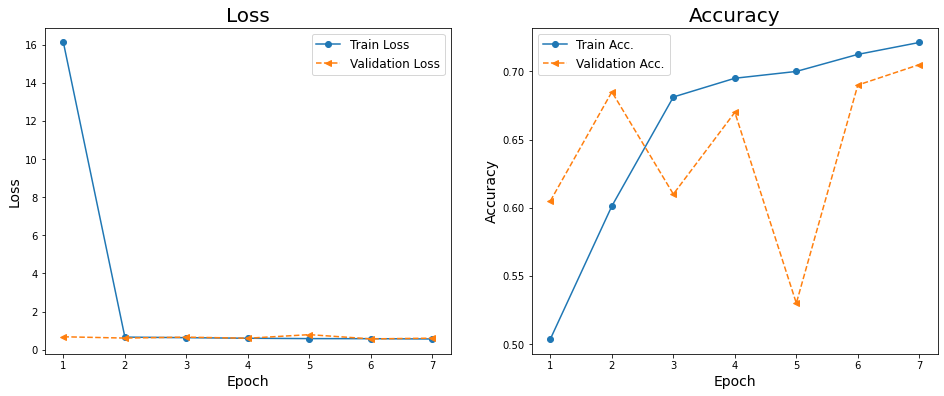

In [ ]:
hist = history.history
x_arr = np.arange(len(hist['loss'])) + 1
# print(x_arr)

fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(1,2,1)
ax.plot(x_arr, hist['loss'], '-o', label='Train Loss')
ax.plot(x_arr, hist['val_loss'], '--<', label='Validation Loss')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Loss', size=14)
ax.set_title('Loss', size=20)

ax = fig.add_subplot(1,2,2)
ax.plot(x_arr, hist['accuracy'], '-o', label='Train Acc.')
ax.plot(x_arr, hist['val_accuracy'], '--<', label='Validation Acc.')
ax.legend(fontsize=12)
ax.set_xlabel('Epoch', size=14)
ax.set_ylabel('Accuracy', size=14)
ax.set_title('Accuracy', size=20);

In [83]:
eval_test = model.evaluate(test_data_generator)
print(f'Test Accuracy: {eval_test[1]*100:.2f}%\n')

eval_train = model.evaluate(train_data_generator)
print(f'Train Accuracy: {eval_train[1]*100:.2f}%')

7/7 [==============================] - 1s 62ms/step - loss: 0.6002 - accuracy: 0.6750
Test Accuracy: 67.50%

25/25 [==============================] - 2s 74ms/step - loss: 0.5477 - accuracy: 0.7237
Train Accuracy: 72.37%
